In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd /content/drive/MyDrive/capstone

/content/drive/MyDrive/capstone


In [3]:
import os

In [4]:
train_images_list = os.listdir('/content/drive/MyDrive/capstone/images_dataset/')

In [5]:
sample_size = 11
train_images_list = train_images_list[:sample_size]

In [6]:
import tensorflow as tf
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random

In [7]:
size = (256, 256)
num_channels = 3

In [8]:
train = np.array([None] * sample_size)
real_images = np.array([None] * sample_size)

In [9]:
j = 0
for i in train_images_list:
    real_images[j] = np.array(plt.imread('/content/drive/MyDrive/capstone/images_dataset/' + i))
    train[j] = np.array(plt.imread('/content/drive/MyDrive/capstone/images_dataset/' + i))
    j += 1

In [10]:
j = 0
for i in train:
    train[j] = cv2.resize(i, size)
    train[j] = train[j].reshape(1, size[0], size[1], num_channels)
    j += 1

In [11]:
train = np.vstack(train[:])

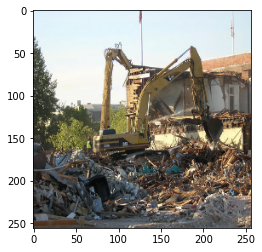

In [12]:
plt.imshow(np.squeeze(train[0]))
plt.show()

In [13]:
import pandas as pd

In [14]:
train_captions = pd.read_csv('/content/drive/MyDrive/capstone/Image_captions (2).csv', delimiter='|')

In [15]:
def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names

In [16]:
# ids = get_images_id(train_images_list[:sample_size])

In [17]:
train_captions.columns = ['image_name', 'comment_number', 'comment']

In [18]:
def images_map_caption(train_images_list, train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions['image_name'] == i]['comment'].iat[0])
    return caption

In [19]:
captions = np.array(images_map_caption(train_images_list, train_captions))
print(captions.shape)

(11,)


In [20]:
import re

In [21]:
start_tag = '<s>'
end_tag = '<e>'

In [22]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = re.sub(' +',' ',i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

In [23]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)

In [24]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [25]:
m = len(sentences)
train_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data, (row, col)), shape=(1, vocab_size))
        else:
            cap_array = vstack((cap_array, csr_matrix((data, (row, col)), shape=(1, vocab_size))))
    train_caption[i] = cap_array
    i += 1

In [26]:
train_caption[0].shape

(19, 124)

# Model Design

## Training Model

In [27]:
def create_weights(shape, suffix):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.7), name='W_' + suffix)

def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]), name='b_' + suffix)

In [28]:
def conv_layer(inp, kernel_shape, num_channels, num_kernels, suffix):
    filter_shape = [kernel_shape[0], kernel_shape[1], num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases = create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=inp, filter=weights, padding='SAME', strides=[1, 1, 1, 1], name='conv_' + suffix)
    layer += biases
    layer = tf.nn.relu6(layer, name='relu_' + suffix)
    #layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
    return layer



In [29]:
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer


In [30]:
def dense_layer(inp, num_inputs, num_outputs, suffix, use_relu=True):
    weights = create_weights([num_inputs, num_outputs], suffix)
    biases = create_biases(num_outputs, suffix)
    layer = tf.matmul(inp, weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [31]:
def rnn_cell(Win ,Wout, Wfwd, b, hprev, inp):
    h = tf.tanh(tf.add(tf.add(tf.matmul(inp, Win), tf.matmul(hprev, Wfwd)), b))
    out = tf.matmul(h, Wo)
    return h, out

In [32]:
import tensorflow as tf

In [33]:
tf.device("/device:GPU:0")

In [34]:
learning_rate = 0.0001
training_iters = 11000
display_step = 1000
max_sent_limit = 50
num_tests = 11
bridge_size = 1024
keep_prob = 0.3

In [35]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [36]:
x_caption = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')
x_inp = tf.placeholder(tf.float32, shape=[1, size[0],size[1],num_channels], name='x_image')
y = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')

In [37]:
Wconv = tf.Variable(tf.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))

In [38]:
layer_conv1 = conv_layer(inp=x_inp, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')
layer_conv2 = conv_layer(inp=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv3 = conv_layer(inp=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')
layer_conv4 = conv_layer(inp=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv5 = conv_layer(inp=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')
layer_conv6 = conv_layer(inp=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv7 = conv_layer(inp=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')
layer_conv8 = conv_layer(inp=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')

In [39]:
flat_layer = flatten_layer(layer_conv8, suffix='9')
#flat_layer = tf.layers.dropout(flat_layer, rate= keep_prob)
dense_layer_1 = dense_layer(inp=flat_layer, num_inputs=262144 , num_outputs=bridge_size, suffix='10')

In [40]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[start_tag]])), shape=(1, vocab_size)).A, tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[end_tag]])), shape=(1, vocab_size)).A, tf.float32)

In [41]:
hook = tf.slice(x_caption, [0, 0], [1, vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi ,Wo, Wconv, bconv, h, hook)

In [42]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, curr)
    return h, out

In [43]:
_, output = tf.scan(fn, x_caption[1:], initializer=(h, out))

In [44]:
output = tf.squeeze(output, axis  = 1)

In [45]:
outputs = tf.concat([out, output], axis = 0)

In [46]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [47]:
pred = tf.nn.softmax(outputs)

In [48]:
# Model evaluation
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Predictive Model

In [49]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size = 0)

In [50]:
htest = dense_layer_1
htest, out_first = rnn_cell(Wi ,Wo, Wconv, bconv, htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1), depth=vocab_size)
out_tensor = out_tensor.write(t, out_)
t += 1

In [51]:
def condition(res, h, out_tensor, t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[end_tag])), tf.less(t, max_sent_limit))

In [52]:
def action(res, h, out_tensor, t):
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h, out_tensor, t + 1

In [53]:
_, __, final_outputs, T = tf.while_loop(condition, action, [out_, htest, out_tensor, t])

In [54]:
final_prediction = tf.squeeze(final_outputs.stack())

In [55]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

# Model Implemetation

After  1000 iterations: Cost =  5.524993859908798 and Accuracy:  51.21968036348169 %
After  2000 iterations: Cost =  3.608527139167894 and Accuracy:  59.67206900770014 %
After  3000 iterations: Cost =  2.9602507440881296 and Accuracy:  64.99526067213579 %
After  4000 iterations: Cost =  2.0616016957739536 and Accuracy:  68.75058764761144 %
After  5000 iterations: Cost =  2.0636081778529016 and Accuracy:  72.66265194524418 %
After  6000 iterations: Cost =  1.613271159119904 and Accuracy:  72.42265966805545 %
After  7000 iterations: Cost =  1.3997725162401118 and Accuracy:  78.56845476410605 %
After  8000 iterations: Cost =  1.5494221489537845 and Accuracy:  76.65874389084902 %
After  9000 iterations: Cost =  1.0530156628228724 and Accuracy:  83.21757966821843 %
After  10000 iterations: Cost =  0.6350071521645243 and Accuracy:  85.67211980169469 %
After  11000 iterations: Cost =  0.7541059295392849 and Accuracy:  85.92326586896723 %
Optimization finished!
Let's check
(12, 124)
Predicted 

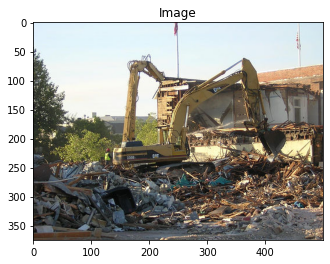

(45, 124)
Predicted Caption:-> A skydiver hangs from the undercarriage of an airplane or some sort of air gliding device basket airplane of air in is a white travel. large grocery white pushing gliding of the an airplane or in two pushing up caring grocery is BBQ . 
Orignal Caption:-> A skydiver hangs from the undercarriage of an airplane or some sort of air gliding device . 


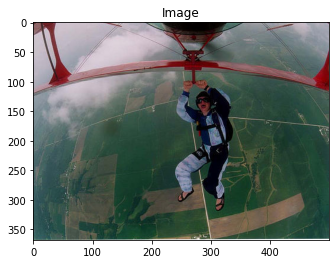

(16, 124)
Predicted Caption:-> A little youngster has fallen asleep on a caring adult's lap after candy sort travel. 
Orignal Caption:-> A little youngster has fallen asleep on a caring adult's lap after a long travel. 


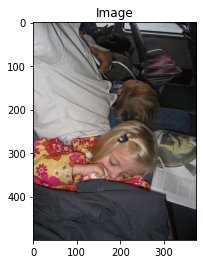

(16, 124)
Predicted Caption:-> They are drinking high caffeinated drinks to sustain energy for their favorite card games . 
Orignal Caption:-> They are drinking high caffeinated drinks to sustain energy for their favorite card games . 


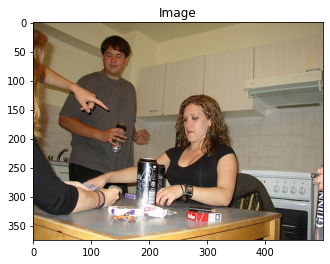

(14, 124)
Predicted Caption:-> The younger martial artist seemed to be in control of the elder contestant. 
Orignal Caption:-> The younger martial artist seemed to be in control of the elder contestant. 


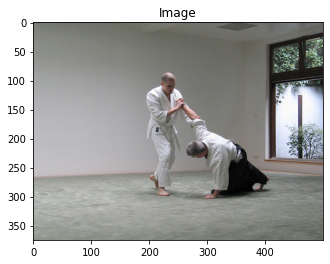

(16, 124)
Predicted Caption:-> A little youngster has fallen asleep on a caring adult's lap after candy sort travel. 
Orignal Caption:-> A little youngster has fallen asleep on a caring adult's lap after a long travel. 


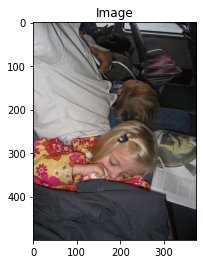

(16, 124)
Predicted Caption:-> They are drinking high caffeinated drinks to sustain energy for their favorite card games . 
Orignal Caption:-> They are drinking high caffeinated drinks to sustain energy for their favorite card games . 


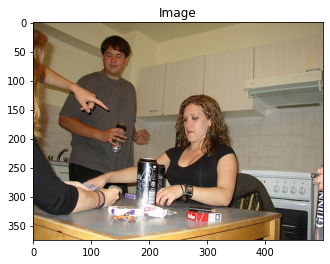

(16, 124)
Predicted Caption:-> A guy and a lady from Mongolian BBQ stand at the counter. gliding elder contestant. 
Orignal Caption:-> A guy and a lady from Mongolian BBQ stand at the counter. 


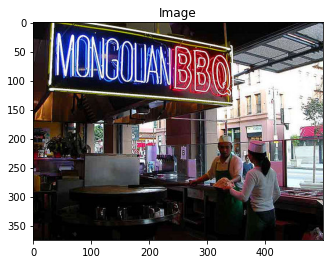

(16, 124)
Predicted Caption:-> They are drinking high caffeinated drinks to sustain energy for their favorite card games . 
Orignal Caption:-> They are drinking high caffeinated drinks to sustain energy for their favorite card games . 


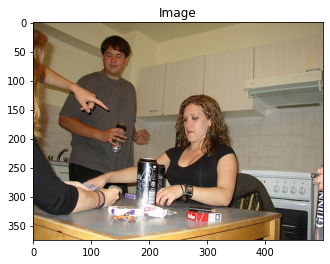

(10, 124)
Predicted Caption:-> Four individuals are eating while seated on the ground. 
Orignal Caption:-> Four individuals are eating while seated on the ground. 


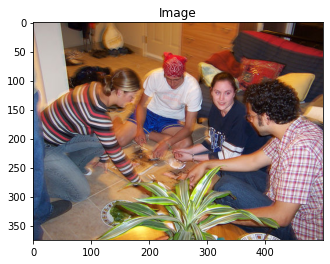

(12, 124)
Predicted Caption:-> A worker in construction gear stands close to the bulldozer rubbish. 
Orignal Caption:-> A worker in construction gear stands close to the bulldozer that is scooping up trash and rubbish. 


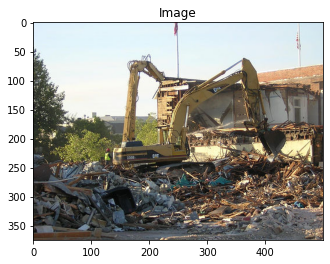

In [56]:
with tf.Session() as sess:
    sess.run(init)
    m = len(train_caption)
    for epoch in range(training_iters):
        total_cost = 0
        total_acc = 0
        for i in range(m):
            _, cst, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x_caption:train_caption[i][:-1].A, x_inp:train[i:i+1], y:train_caption[i][1:].A})
            total_cost += cst
            total_acc += acc
        if (epoch + 1) % display_step == 0:
            print('After ', (epoch + 1), 'iterations: Cost = ', total_cost / m, 'and Accuracy: ', total_acc * 100/ m , '%' )
    print('Optimization finished!')
    print("Let's check")
    for tests in range(num_tests):
        image_num = random.randint(0, sample_size - 1)
        caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
        print(caption.shape)
        caption = np.argmax(caption[:-1], 1)
        capt = ''
        for i in caption:
            capt += rev_dict[i] + ' '
        print('Predicted Caption:->', capt)
        orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
        orignalcaption = ''
        for i in orig_cap:
            orignalcaption += rev_dict[i] + ' '
        print('Orignal Caption:->', orignalcaption)
        plt.imshow(real_images[image_num])
        plt.title('Image')
        plt.show()